In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import warnings
import tensorflow as tf
import seaborn as sns
import sklearn
import random
import math
import time


from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, GRU
from scipy import optimize
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA

from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *
from methods import *

%matplotlib inline
warnings.filterwarnings('ignore')

SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Appeler la fonction pour fixer le seed
set_seed(SEED)

# FD001

In [3]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD001.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
                    'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

# rul_piecewise = 120
# train['RUL'].clip(upper=rul_piecewise, inplace=True)

## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(20631, 27) (13096, 26) (100, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,-0.0,-0.0,100.0,0.0,0.168712,0.419699,0.281998,0.0,...,0.186883,0.364675,0.0,0.333333,0.0,0.0,0.779661,0.750000,191,-0.0_-0.0_100.0
1,1,2,0.0,-0.0,100.0,0.0,0.231676,0.437236,0.301955,0.0,...,0.180816,0.382647,0.0,0.301435,0.0,0.0,0.749952,0.736399,190,0.0_-0.0_100.0
2,1,3,-0.0,0.0,100.0,0.0,0.279270,0.414066,0.334500,0.0,...,0.168127,0.371184,0.0,0.227105,0.0,0.0,0.713728,0.699766,189,-0.0_0.0_100.0
3,1,4,0.0,0.0,100.0,0.0,0.295582,0.363296,0.318775,0.0,...,0.168159,0.315365,0.0,0.266806,0.0,0.0,0.671042,0.684862,188,0.0_0.0_100.0
4,1,5,-0.0,-0.0,100.0,0.0,0.305799,0.336489,0.335855,0.0,...,0.166419,0.338028,0.0,0.310184,0.0,0.0,0.664455,0.695191,187,-0.0_-0.0_100.0


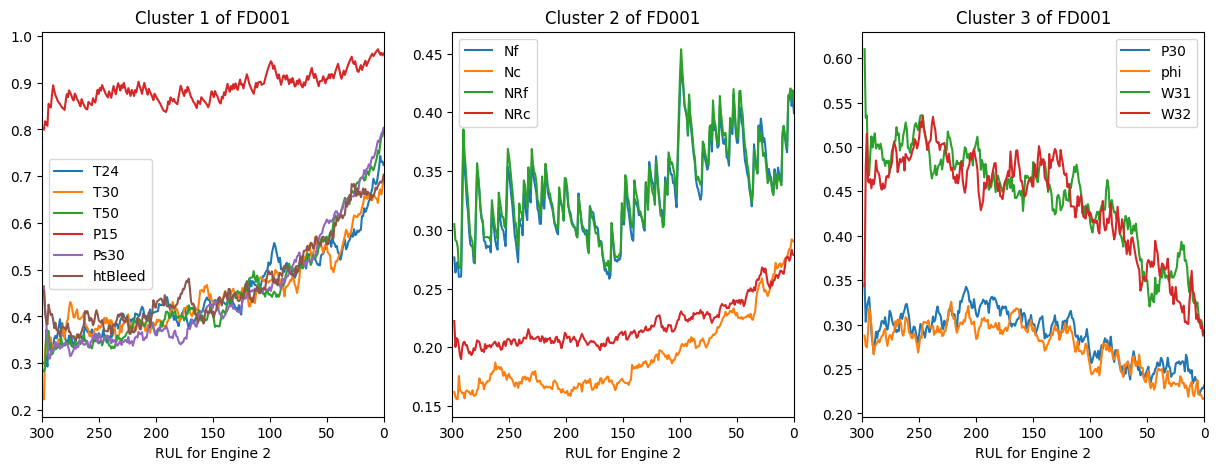

In [32]:
list_cluster = [[ 'T24', 'T30', 'T50', 'P15', 'Ps30', 'htBleed'],
                ['Nf', 'Nc', 'NRf', 'NRc'],
                ['P30', 'phi', 'W31', 'W32']]
C=1
plt.figure(figsize=(15,5))
for cluster in list_cluster:
    # plt.figure(figsize=(8,8))
    plt.subplot(1,3,C)
    for s in cluster:
        # signal = X_train_interim[X_train_interim.Unit == 1 ][s]
        # RUL = X_train_interim[X_train_interim.Unit == 1 ]['RUL']
        df = X_train_interim
        # Plotting the histogram and density plot
        # plt.figure(figsize=(10, 6))
        # plt.subplot(3,3,s+1)
        plt.plot('RUL', s, label = s, data=df[df['Unit']==2])  # kde=True adds a kernel density estimate
        # plt.title("Distribution of Signal")
        plt.xlim(300, 0)  # reverse the x-axis so RUL counts down to zero
        plt.xticks(np.arange(0, 325, 50))
        # plt.ylabel('Features')
        plt.xlabel('RUL for Engine 2')
    plt.legend()
    plt.title(f'Cluster {C} of FD001')
    C = C+1
plt.savefig('images/clusterfd001.png')
plt.show()

### FD002

In [15]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD002.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
                    'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

# rul_piecewise = 120
# train['RUL'].clip(upper=rul_piecewise, inplace=True)
# ## Data cleaning
alpha = 0.3
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(53759, 27) (33991, 26) (259, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,35.0,0.84,100.0,0.0,0.325733,0.271554,0.561254,0.0,...,0.052796,0.497413,0.0,0.400000,0.0,0.0,0.373494,0.323963,148,35.0_0.84_100.0
1,1,2,42.0,0.84,100.0,0.0,0.447218,0.357533,0.470959,0.0,...,0.095143,0.456428,0.0,0.360784,0.0,0.0,0.309302,0.391651,147,42.0_0.84_100.0
2,1,3,25.0,0.62,60.0,0.0,0.553232,0.355037,0.466030,0.0,...,0.110085,0.414226,0.0,0.470015,0.0,0.0,0.286071,0.531223,146,25.0_0.62_60.0
3,1,4,42.0,0.84,100.0,0.0,0.495285,0.387258,0.447732,0.0,...,0.107374,0.381830,0.0,0.372189,0.0,0.0,0.359184,0.632675,145,42.0_0.84_100.0
4,1,5,25.0,0.62,60.0,0.0,0.528642,0.383824,0.455578,0.0,...,0.104597,0.378322,0.0,0.454340,0.0,0.0,0.343109,0.552861,144,25.0_0.62_60.0


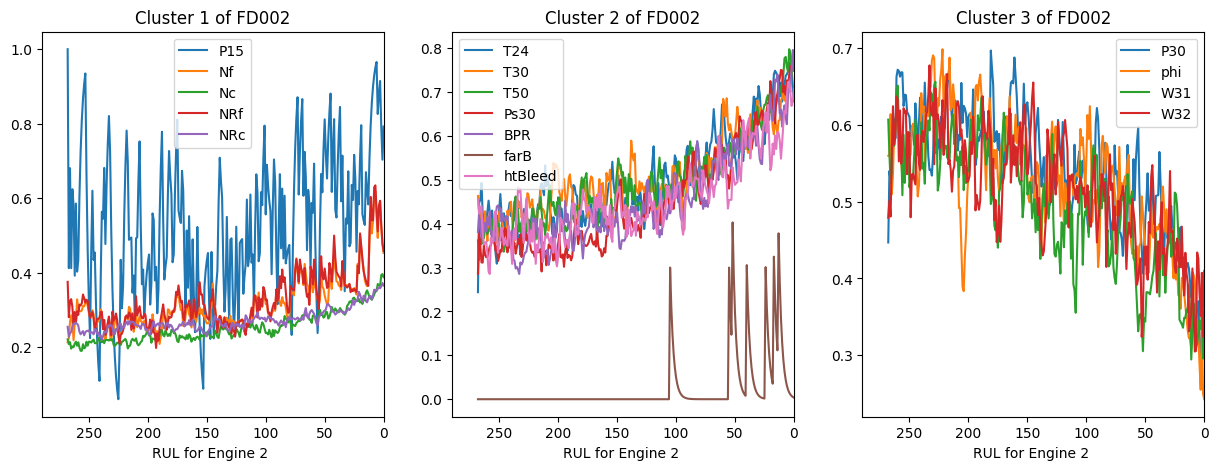

In [23]:
list_cluster = [['P15', 'Nf', 'Nc', 'NRf', 'NRc'],
                [ 'T24', 'T30', 'T50','Ps30','BPR', 'farB', 'htBleed'],
                ['P30', 'phi', 'W31', 'W32']]
C=1
plt.figure(figsize=(15,5))
for cluster in list_cluster:
    # plt.figure(figsize=(8,8))
    plt.subplot(1,3,C)
    for s in cluster:
        # signal = X_train_interim[X_train_interim.Unit == 1 ][s]
        # RUL = X_train_interim[X_train_interim.Unit == 1 ]['RUL']
        df = X_train_interim
        # Plotting the histogram and density plot
        # plt.figure(figsize=(10, 6))
        # plt.subplot(3,3,s+1)
        plt.plot('RUL', s, label = s, data=df[df['Unit']==2])  # kde=True adds a kernel density estimate
        # plt.title("Distribution of Signal")
        plt.xlim(290, 0)  # reverse the x-axis so RUL counts down to zero
        plt.xticks(np.arange(0, 290, 50))
        # plt.ylabel('Features')
        plt.xlabel('RUL for Engine 2 ')
    plt.legend()
    plt.title(f'Cluster {C} of FD002')
    C = C+1
plt.savefig('images/clusterfd002.png')
plt.show()

#### FD003

In [24]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD003.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
                    'NRf','NRc','BPR','htBleed','W31','W32']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

# rul_piecewise = 125
# train['RUL'].clip(upper=rul_piecewise, inplace=True)
## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(24720, 27) (16596, 26) (100, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,-0.0,0.0,100.0,0.0,0.378788,0.341211,0.279748,0.0,...,0.238238,0.618635,0.0,0.272727,0.0,0.0,0.546584,0.469595,258,-0.0_0.0_100.0
1,1,2,0.0,-0.0,100.0,0.0,0.403623,0.371855,0.295333,0.0,...,0.270487,0.639660,0.0,0.320574,0.0,0.0,0.515568,0.505576,257,0.0_-0.0_100.0
2,1,3,-0.0,-0.0,100.0,0.0,0.376607,0.365007,0.349504,0.0,...,0.273559,0.596319,0.0,0.302918,0.0,0.0,0.478323,0.472777,256,-0.0_-0.0_100.0
3,1,4,-0.0,0.0,100.0,0.0,0.426586,0.372434,0.306566,0.0,...,0.265180,0.574722,0.0,0.320574,0.0,0.0,0.471081,0.455219,255,-0.0_0.0_100.0
4,1,5,0.0,0.0,100.0,0.0,0.370454,0.395376,0.307426,0.0,...,0.268241,0.570330,0.0,0.331090,0.0,0.0,0.495162,0.473204,254,0.0_0.0_100.0


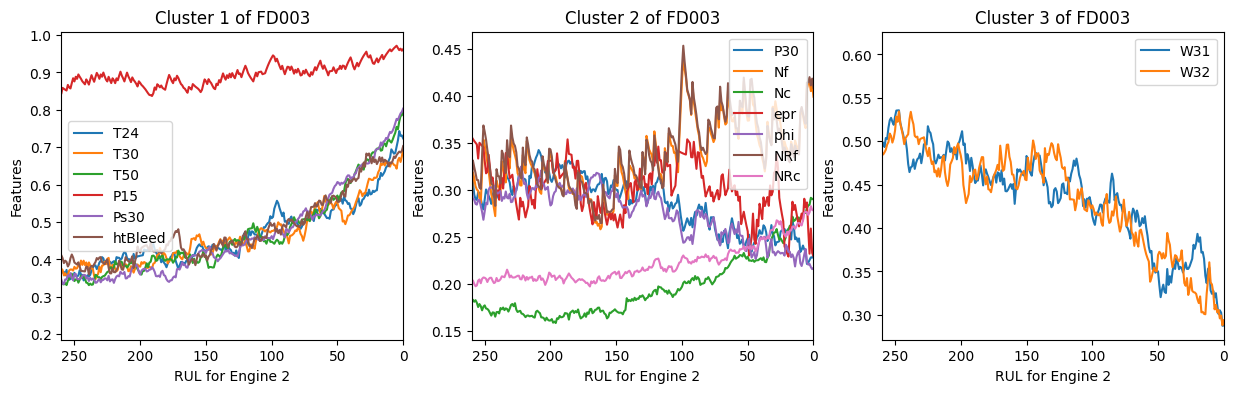

In [33]:
list_cluster = [['T24', 'T30', 'T50', 'P15', 'Ps30', 'htBleed'],
                ['P30', 'Nf', 'Nc', 'epr', 'phi', 'NRf', 'NRc'],
                ['W31', 'W32']]
C=1
plt.figure(figsize=(15,4))
for cluster in list_cluster:
    # plt.figure(figsize=(8,8))
    plt.subplot(1,3,C)
    for s in cluster:
        # signal = X_train_interim[X_train_interim.Unit == 1 ][s]
        # RUL = X_train_interim[X_train_interim.Unit == 1 ]['RUL']
        df = X_train_interim
        # Plotting the histogram and density plot
        # plt.figure(figsize=(10, 6))
        # plt.subplot(3,3,s+1)
        plt.plot('RUL', s, label = s, data=df[df['Unit']==2])  # kde=True adds a kernel density estimate
        # plt.title("Distribution of Signal")
        plt.xlim(260, 0)  # reverse the x-axis so RUL counts down to zero
        plt.xticks(np.arange(0, 260, 50))
        plt.ylabel('Features')
        plt.xlabel('RUL for Engine 2')
    plt.legend()
    plt.title(f'Cluster {C} of FD003')
    C = C+1
plt.savefig('images/clusterfd003.png')
plt.show()

### FD004

In [28]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD004.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
                    'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

# rul_piecewise = 120
# train['RUL'].clip(upper=rul_piecewise, inplace=True)
## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(61249, 27) (41214, 26) (248, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,42.0,0.84,100.0,0.0,0.500000,0.255293,0.278866,0.0,...,0.175935,0.602638,0.0,0.363636,0.0,0.0,0.460000,0.473138,320,42.0_0.84_100.0
1,1,2,20.0,0.70,100.0,0.0,0.296544,0.297306,0.246618,0.0,...,0.144143,0.589484,0.0,0.220096,0.0,0.0,0.374584,0.424327,319,20.0_0.7_100.0
2,1,3,42.0,0.84,100.0,0.0,0.293314,0.279496,0.284639,0.0,...,0.137238,0.645445,0.0,0.239517,0.0,0.0,0.354442,0.475873,318,42.0_0.84_100.0
3,1,4,42.0,0.84,100.0,0.0,0.270575,0.259617,0.308441,0.0,...,0.150673,0.635035,0.0,0.222739,0.0,0.0,0.361874,0.499703,317,42.0_0.84_100.0
4,1,5,25.0,0.62,60.0,0.0,0.258382,0.274522,0.277455,0.0,...,0.155717,0.603815,0.0,0.249746,0.0,0.0,0.327772,0.530466,316,25.0_0.62_60.0


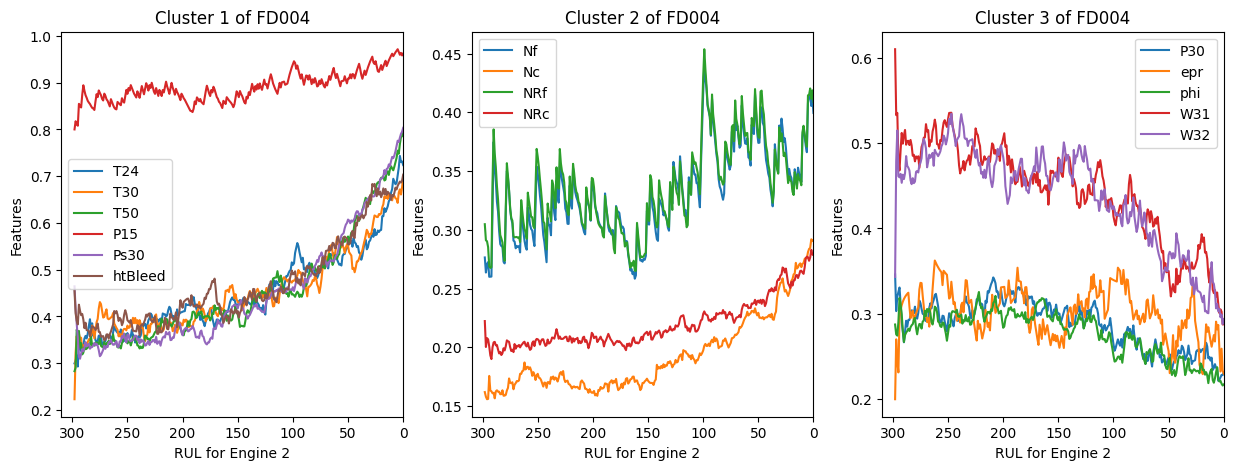

In [31]:
list_cluster = [['T24', 'T30', 'T50', 'P15', 'Ps30', 'htBleed'],
                [  'Nf', 'Nc', 'NRf', 'NRc'],
                ['P30', 'epr', 'phi', 'W31', 'W32']]
C=1
plt.figure(figsize=(15,5))
for cluster in list_cluster:
    # plt.figure(figsize=(8,8))
    plt.subplot(1,3,C)
    for s in cluster:
        # signal = X_train_interim[X_train_interim.Unit == 1 ][s]
        # RUL = X_train_interim[X_train_interim.Unit == 1 ]['RUL']
        df = X_train_interim
        # Plotting the histogram and density plot
        # plt.figure(figsize=(10, 6))
        # plt.subplot(3,3,s+1)
        plt.plot('RUL', s, label = s, data=df[df['Unit']==2])  # kde=True adds a kernel density estimate
        # plt.title("Distribution of Signal")
        plt.xlim(310, 0)  # reverse the x-axis so RUL counts down to zero
        plt.xticks(np.arange(0, 310, 50))
        plt.ylabel('Features')
        plt.xlabel('RUL for Engine 2')
    plt.legend()
    plt.title(f'Cluster {C} of FD004')
    C = C+1
plt.savefig('images/clusterfd004.png')
plt.show()